## Preparing for Docking: Defining a Ligand Box

In [1]:
import sys
print(sys.executable)
print(sys.version)

C:\Users\carlo\anaconda3\envs\vina-env\python.exe
3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:42:04) [MSC v.1943 64 bit (AMD64)]


In [5]:
import MDAnalysis as mda

original_structure = mda.Universe("protein_structures/7ddl.pdb")
ligand_mda = original_structure.select_atoms("resname BUF")

# Get the center of the ligand as the "pocket center"
pocket_center = ligand_mda.center_of_geometry()## Fill in code for measuring the center of geometry of the ligand.
print(pocket_center)

C:\Users\carlo\anaconda3\envs\vina-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[16.55462501  8.02226785 60.59587513]


After defining the pocket center, we will define our ligand box.
One simple approach to this is to subtract the min and max of the ligand positions in each dimension.
In order to allow for ligand flexibility and potential interactions with nearby residues, we will add an additional five angstroms to each side of our box.

In [8]:
ligand_box = ligand_mda.positions.max(axis=0) - ligand_mda.positions.min(axis=0) +5 ## Fill in the rest of this expression.
ligand_box

array([39.412003, 69.431   , 34.248   ], dtype=float32)

## Docking Ligands with AutoDock Vina

Now that we have PDBQT files of our protein and ligand and have defined our docking box, we are ready to perform the actual docking.
Before docking, we will make a directory to store our results.

In [15]:
# make a directory to store our results
import os

pdb_id = "7ddl"
ligand = "BUF"

## Make a directory called "docking_results"
os.makedirs("docking_results",exist_ok=True)

I couldn't make vina run in my notebook because the python version of vina always downloaded with missing files. To correct this error I ran vina from bash in Ubuntu with the following script: 

## Bash input

vina --receptor pdbqt/7ddl.pdbqt \
     --ligand pdbqt/resBUF.pdbqt \
     --center_x 16.55462501 --center_y 8.02226785 --center_z 60.59587513 \
     --size_x 39.412003 --size_y 69.431 --size_z 34.248 \
     --exhaustiveness 10 \
     --num_modes 5 \
     --out docking_results/resBUF.pdbqt

As one can see, I have included the important information we have previously gotten form ligand box in size and pocket center for center. 

## Bash output

The result was the following: 

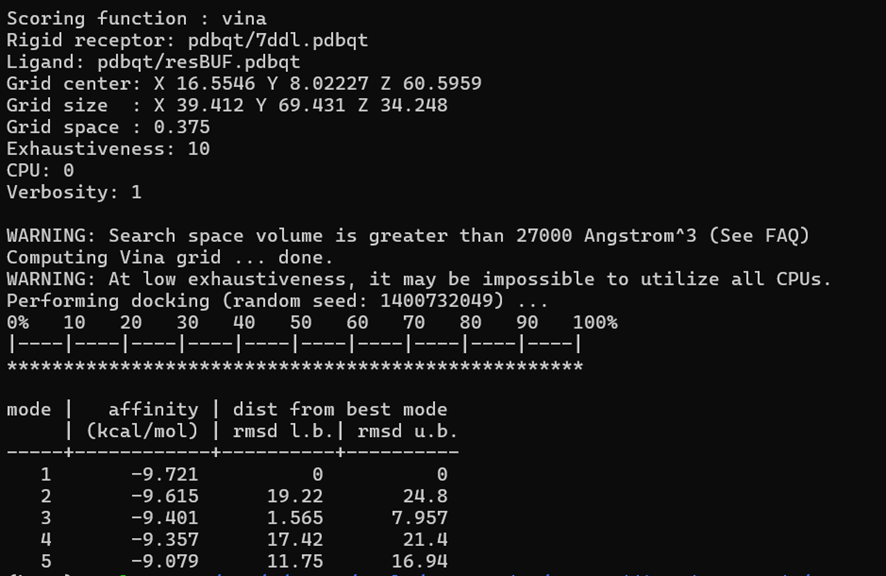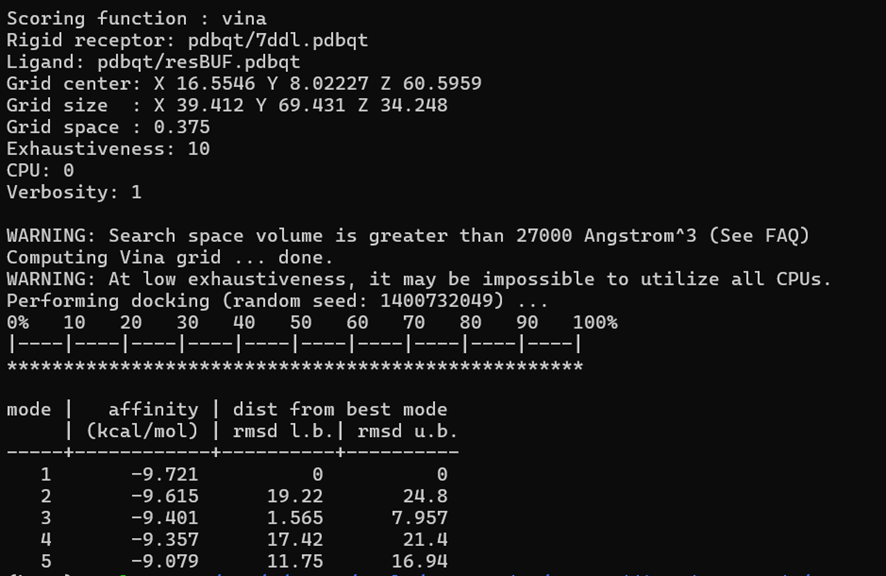

The more detailed version is in the output pdbqt, where for each model it gave the following information:

MODEL 1 

REMARK VINA RESULT:    -9.721      0.000      0.000 

REMARK INTER + INTRA:         -11.184

REMARK INTER:                 -10.858

REMARK INTRA:                  -0.326

REMARK UNBOUND:                -0.326


REMARK  3 active torsions:

REMARK  status: ('A' for Active; 'I' for Inactive)

REMARK    1  A    between atoms: C_10  and  O_11 

REMARK    2  A    between atoms: C_17  and  O_18 

REMARK    3  A    between atoms: C_21  and  C_22 

In [35]:
## As for every iteration of the process form bash rewrites the output file, here are the results for the recomended parameters of 32 exhaustiveness and 
## 10 modes

import re
import pandas as pd

file_path = "docking_results/resBUF.pdbqt"

with open(file_path, 'r') as f:
    lines = f.readlines()

models = []
current = {}

for line in lines:
    line = line.strip()
    if line.startswith("MODEL"):
        if current:
            models.append(current)
        current = {"Model": int(line.split()[1])}
    elif line.startswith("REMARK VINA RESULT:"):
        current["Vina_Result"] = float(line.split()[3])
    elif line.startswith("REMARK INTER + INTRA:"):
        current["Inter+Intra"] = float(line.split()[-1]) 
    elif line.startswith("REMARK INTER:"):
        current["Inter"] = float(line.split()[-1])
    elif line.startswith("REMARK INTRA:"):
        current["Intra"] = float(line.split()[-1])   
    elif line.startswith("REMARK UNBOUND:"):
        current["Unbound"] = float(line.split()[-1]) 

if current:
    models.append(current)

df = pd.DataFrame(models)
df.sort_values("Model", inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Model,Vina_Result,Inter+Intra,Inter,Intra,Unbound
0,1,-9.708,-11.175,-10.844,-0.331,-0.331
1,2,-9.628,-11.085,-10.745,-0.340,-0.331
2,3,-9.442,-10.877,-10.614,-0.263,-0.331
3,4,-9.434,-10.868,-10.531,-0.337,-0.331
4,5,-9.428,-10.862,-10.587,-0.275,-0.331
5,6,-9.387,-10.816,-10.557,-0.259,-0.331
6,7,-9.219,-10.628,-10.545,-0.083,-0.331
7,8,-9.205,-10.613,-10.376,-0.237,-0.331
8,9,-9.104,-10.500,-10.137,-0.363,-0.331
9,10,-9.084,-10.477,-10.152,-0.326,-0.331


In [23]:
df.to_csv("resBUF_full_docking_results.csv", index=False)

## Visualizing Docking Results

After performing the docking simulation and saving the energies, you might wish to visualize the poses. 
When visualizing results from molecular docking, scientists often visually inspect the 3D docked structure as well as a 2D representation called an interaction map.
We can ues a software called ProLIF (Protein-Ligand Interaction Fingerprints) to make and view these maps in the Jupyter notebook.

To generate these visualizations, we have to convert our files (again!) to the correct format.

In the step above, we wrote the poses to the file `docking_results/13U.pdbqt`. 
AutoDock Vina only writes in this file, but in order to visualize your results, we need a more standard format.
We will use meeko again to convert our poses to an SDF.
Note that meeko will only convert pdbqt files if it prepared the input docking files, which is one reason we used it in the previous notebook.

Again, we use a command line script to convert out poses.

In [27]:
! mk_export.py docking_results/resBUF.pdbqt -s docking_results/resBUF.sdf # In the original workshop, `mk_export.py` used the option `-o` instead of `-s`. This was changed to `-s` in late 2024.

After converting to SDF, we can again visualize our results with ProLIF.
ProLIF requires that molecules be loaded in and has functions to load molecules in several ways.
We will use MDAnalysis for loading our proteins to ProLIF and `sdf_supplier` to load the SDFs we converted in the previous step.

In [25]:
import prolif as plf
import MDAnalysis as mda

pdb_id = "7ddl"

protein = mda.Universe(f"protein_structures/protein_h.pdb")

ModuleNotFoundError: No module named 'prolif'

Next, we load our protein and ligand into ProLIF.
The function we use to do this depends on the format of our input data.

In [ ]:
protein_plf = plf.Molecule.from_mda(protein)
poses_plf = plf.sdf_supplier() # fill in filename here

To analyze the interactions of the ligand and protein we create a molecular fingerprint object.
By default, ProLIF will calculate nine types of interactions: 'Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'
However, you could set this to different interactions. You can see more information about the types of interactions in the [ProLIF docs](https://prolif.readthedocs.io/en/latest/source/modules/interaction-fingerprint.html#detecting-interactions-between-residues-prolif-interactions-interactions).

In [ ]:
fp = plf.Fingerprint(count=True)

Next, we will run ProLif on our poses.
To do this calculation, we pass in our list of poses (`poses_plf`) and our ProLIF protein.

In [ ]:
# run on your poses
fp.run_from_iterable() ## fill in this function

After running this analysis, we can visualize the interaction results.
We are using the 2D and 3D visualization maps here, but there are [many other types of analysis](https://prolif.readthedocs.io/en/latest/notebooks/docking.html#analysis) that you can perform.

In [ ]:
pose_index=1

In [ ]:
fp.plot_lignetwork(poses_plf[pose_index])

In [ ]:
view = fp.plot_3d(
    poses_plf[pose_index], protein_plf, frame=pose_index, display_all=False
)
view

<div class="alert alert-block alert-warning"> 
<h3>Exercise</h3>

Try docking one of the ligands we modified in the previous notebook. Does it bind better or worse according to the docking score? Are the interactions different for the poses?
</div>